# DeepDreaming with TensorFlow

#modified by FBB (@fedhere) for UD DSPS 2019 class last updated for DSPS 2021 including upgrading to python3 and current version of TF

### ___Alex Mordvintsev___

This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

###  Load the model graph

The pretrained Inception network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). This next cell downloads the file automatically and unpacks it locally to the Colab kernel. We can the load the contained model file  'tensorflow_inception_graph.pb' in the cell below.

In [239]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
import pylab as pl
import random
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.compat.v1.InteractiveSession(graph=graph)
with tf.compat.v2.io.gfile.GFile(model_fn, 'rb') as f:

    graph_def = tf.compat.v1.GraphDef()   # -> instead of tf.GraphDef() 
    graph_def.ParseFromString(f.read())
t_input = tf.compat.v1.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

File ‘inception5h.zip’ already there; not retrieving.

Archive:  inception5h.zip


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


make sure you are running on the GPUs - on the notebook menu go to 

Runtime\-\>Change Runtime type




In [240]:
!wget https://github.com/fedhere/DSPS_FBianco/raw/master/HW9/runtime.png

--2021-12-01 22:33:22--  https://github.com/fedhere/DSPS_FBianco/raw/master/HW9/runtime.png
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW9/runtime.png [following]
--2021-12-01 22:33:22--  https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW9/runtime.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50464 (49K) [image/png]
Saving to: ‘runtime.png.4’

runtime.png.4       100%[===================>]  49.28K  --.-KB/s    in 0.01s   

2021-12-01 22:33:22 (4.93 MB/s) - ‘runtime.png.4’ saved [50464/50464]



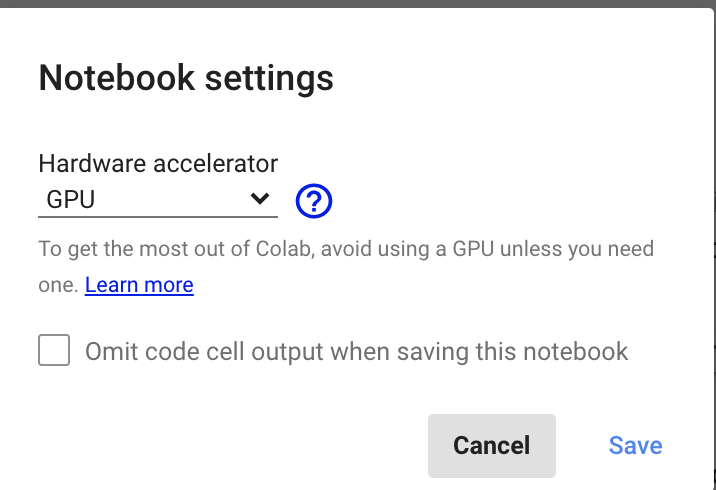

In [241]:
from IPython.display import Image
Image(filename='runtime.png') 

In [242]:
def showarray(a, fmt='jpeg'):
    #if a is > 3 axis cut the last one assuming its alpha-transparency 
    if a.shape[-1] == 4:
      a = a[:,:,:3]
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    


# Task 1: Create a random noise "image": 
an array of 300x300 pixels and 3 color channels (RGB). Fill it in with random noise but make sure the values are Unsigned integer 8bit type (np.unit8) and contained between 0 and 255. This is how a jpg image would be encoded in python and both pylab and this base code require this encoding for the image.  This can be achieved by generating random uniform noise (between 0 and 1) and convert it to 0-255 by multiplication, then convert the data type

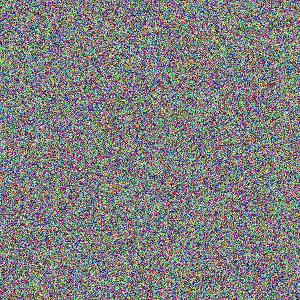

In [243]:
np.random.seed(101)
rnd = (np.random.rand(300*300*3).reshape(300,300,3)*255).astype(np.uint8)
showarray(rnd)


In [244]:
np.random.seed(101)
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.compat.v1.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img



# Task 2 start a deep dream : 

Adjust the sliders to change the strength of the deep dream, and how many scales it is applied over and until you obtain a "phsychadelic" result that you like

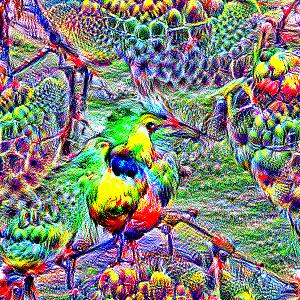

In [245]:
octave_n = 7 #@param {type:"slider", max: 10}
octave_scale = 1.3 #@param {type:"number"}
iter_n = 50 #@param {type:"slider", max: 50}
strength = 400 #@param {type:"slider", max: 1000}
layer = "mixed5a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

print('Number of layers', len(layers))

start = render_deepdream(tf.square(T(layer)), rnd)


 # Task 3 pull each layer: 
 look at the bottom diagram that shows the architecture of the layer. Plot each relevant layer: the layers that start with "mixed"  

**NOTE:**

since I am using

In [246]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

id=0
for layer in layers:
  id+=1;
  print('Layer ', id,':\t', layer)

Number of layers 59
Total number of feature channels: 7548
Layer  1 :	 import/conv2d0_pre_relu/conv
Layer  2 :	 import/conv2d1_pre_relu/conv
Layer  3 :	 import/conv2d2_pre_relu/conv
Layer  4 :	 import/mixed3a_1x1_pre_relu/conv
Layer  5 :	 import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer  6 :	 import/mixed3a_3x3_pre_relu/conv
Layer  7 :	 import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer  8 :	 import/mixed3a_5x5_pre_relu/conv
Layer  9 :	 import/mixed3a_pool_reduce_pre_relu/conv
Layer  10 :	 import/mixed3b_1x1_pre_relu/conv
Layer  11 :	 import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer  12 :	 import/mixed3b_3x3_pre_relu/conv
Layer  13 :	 import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer  14 :	 import/mixed3b_5x5_pre_relu/conv
Layer  15 :	 import/mixed3b_pool_reduce_pre_relu/conv
Layer  16 :	 import/mixed4a_1x1_pre_relu/conv
Layer  17 :	 import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer  18 :	 import/mixed4a_3x3_pre_relu/conv
Layer  19 :	 import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer 

..

..

..

..

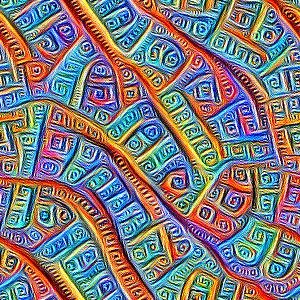

In [249]:
layerM3a = render_deepdream(tf.square(T("mixed3a")), rnd);

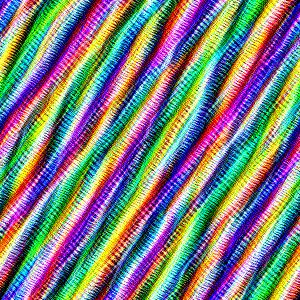

In [250]:
layerM3b = render_deepdream(tf.square(T("mixed3b")), rnd);

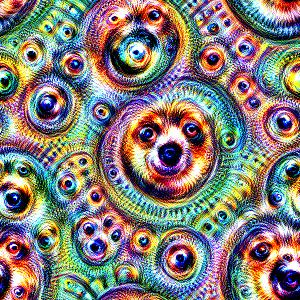

In [251]:
layerM4a = render_deepdream(tf.square(T("mixed4a")), rnd);

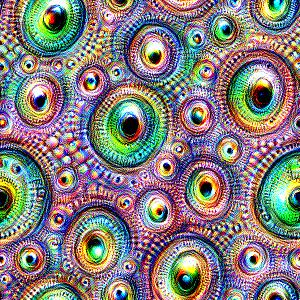

In [252]:
layerM4b = render_deepdream(tf.square(T("mixed4b")), rnd);

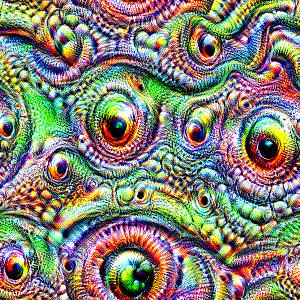

In [253]:
layerM4c = render_deepdream(tf.square(T("mixed4c")), rnd);

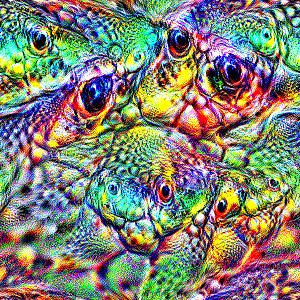

In [254]:
layerM4d = render_deepdream(tf.square(T("mixed4d")), rnd);

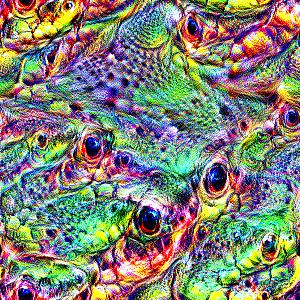

In [255]:
layerM4e = render_deepdream(tf.square(T("mixed4e")), rnd);

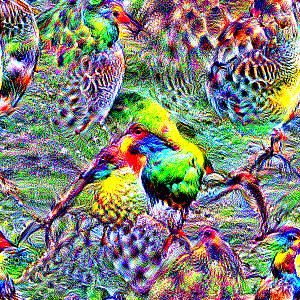

In [256]:
layerM5a = render_deepdream(tf.square(T("mixed5a")), rnd);

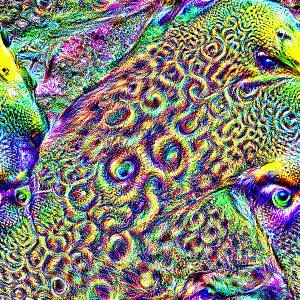

In [257]:
layerM5b = render_deepdream(tf.square(T("mixed5b")), rnd);

# Task 4:  Qalitatively describe
based on your understanding and reading, why the layers show different features and what it the "kind" of features extracted in the earler layers vs the later ones.


Each 'Layer' seems to have been trained with different images, although a common trend within mixed5 is that each individual layer appears to be organic in some way.

In the early layers, everything is very basic and geometric, while in the end layers, there is a great amount of complexity. This makes sense because each added layer is a new added set of machine learning neurons for the AI to process input, which explains why the early layers can only produce/recognize simple geometries, while the later layers seem to include vivid objects, lighting, and sometimes recognizable organisms.

The first layers' neurons are used for geometry, then the following layers identify objects and dimensionality, while the final layers are capable of combining all lesser information to draw a more complete interpretation/illustration of the given image.

...

# Task 5: Load your chosen image 
must be at least 600 pixels in each size

In [258]:
from google.colab import files
uploaded = files.upload()

Saving Cat (original).jfif to Cat (original).jfif


In [259]:
if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[list(uploaded.keys())[0]]

In [260]:
tf.io.decode_image(file_contents)

<tf.Tensor 'decode_image/DecodeImage:0' shape=<unknown> dtype=uint8>

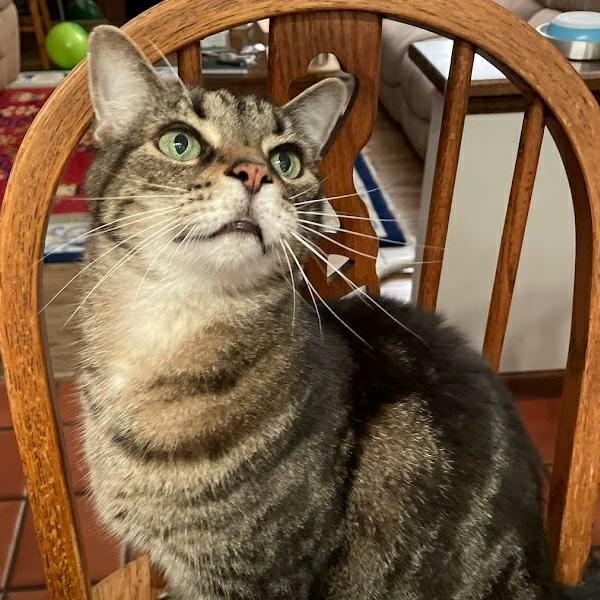

In [261]:
img0 = sess.run(tf.io.decode_image(file_contents))
showarray(img0)


# Task 6: shrink it to 600 pixels along the x axis by subsampling 


In [262]:
img0.shape

(600, 600, 3)

In [263]:
basewidth = 600
img1 = img0.copy()

if img0.shape[0] > basewidth:
  step = int(float(img0.shape[0] / basewidth))
  if img0.shape[-1] == 4:
    img0 = img0[:,:,:3]

  img1 = img0.copy()
  img1 = img1[::step]
elif img0.shape[0] < basewidth:
  import scipy
  img1 = scipy.ndimage.zoom(img0, zoom=(2, 1,1), order=1)


# Task 7: Repeat step 4, DeepDream, with your image. 
Save the layer you like. Upload tha original and modified image to the readme file of your DSPS repo



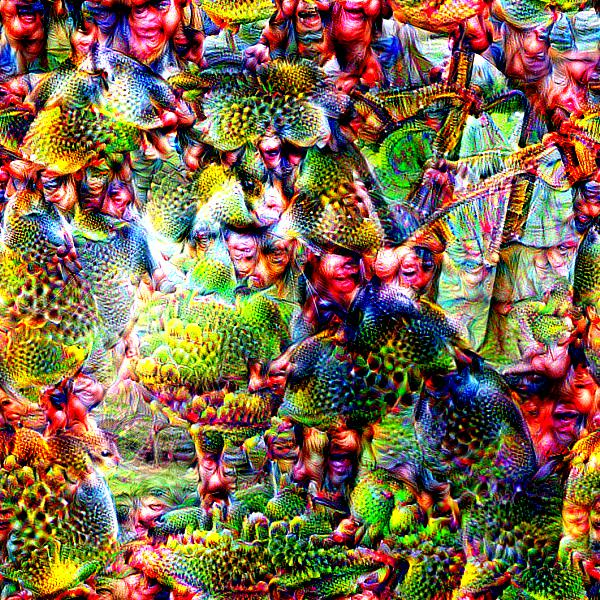

In [264]:

img2 = render_deepdream(tf.square(T("mixed5a")), img1)

**What I originally got [Cat(processed_0)]:**

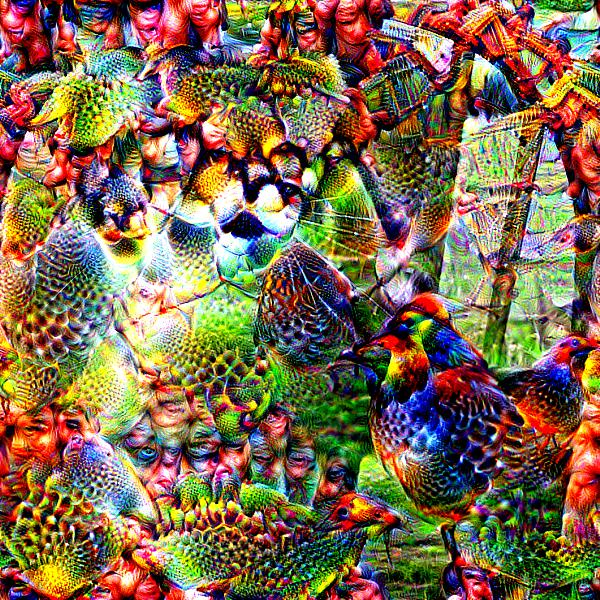

# Task 8: Answer: Are there "animals" in your image? why? (there should be)


Does this modified image contain animals that were not present in the original?

Yes! in the bottom right area, one might be able to make out the form of two birds, both with primary colored feathers. To the left of them, there are also lots of veiled, pink and blue faces.

Why do these "animals" appear?

When the algorithm identifies something that vaguely looks like an animal, earlier on in the iteration process, the AI will make more of that feature. Now that there is even more of that feature, the AI will recognize it with even more potency. This results in a positive feedback loop such that something that barely looked like an animal will become a very distinct feature of the modified image.

### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe